# Processing Data

In [1]:
pip install compressai

     |████████████████████████████████| 295 kB 7.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
import math
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
#from torchvision import transforms
from torch.utils.data import Dataset

from compressai.entropy_models import EntropyBottleneck
from compressai.layers import GDN
from compressai.models import CompressionModel
from compressai.models.utils import conv, deconv, quantize_ste
import pdb

In [4]:
img_test = sorted(glob.glob("/content/drive/MyDrive/Project/test/*.png"))
img_train = sorted(glob.glob("/content/drive/MyDrive/Project/train/*.jpg"))
print ("Collected {} test images".format(len(img_test)))
print ("Collected {} train images".format(len(img_train)))

Collected 24 test images
Collected 512 train images


cpu


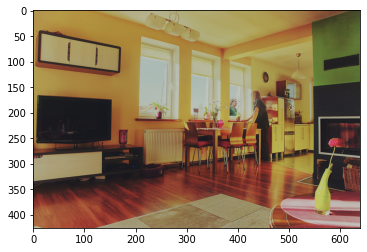

In [5]:
img = cv2.imread(img_train[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
plt.figure()
plt.imshow(img)

In [6]:
class MAE(nn.Module):
    def __init__(self, N=128):
        super().__init__()
        self.FC1 = nn.Linear(1, int(N/2))
        self.relu = nn.ReLU()
        self.FC2 = nn.Linear(int(N/2), N)
        #self.sig = nn.Sigmoid()
        
    def forward(self, lmda):
        x = torch.tensor([lmda],dtype = torch.float)
        x = torch.unsqueeze(x,0)
        x = self.FC1(x)
        x = self.relu(x)
        x = self.FC2(x)
        x = torch.exp(x)
        #x = 2*self.sig(x)
        
        x = torch.unsqueeze(torch.unsqueeze(x,-1),-1)
        return x

# Network

In [7]:
class Network(CompressionModel):
    def __init__(self, N=128):
        super().__init__(N)
        self.conv1 = conv(3, N)
        self.gdn1 = GDN(N)
        self.conv2 = conv(N, N)
        self.gdn2 = GDN(N)
        self.conv3 = conv(N, N)
        self.gdn3 = GDN(N)
        
        self.deconv1 = deconv(N, N)
        self.igdn1 = GDN(N, inverse=True)
        self.deconv2 = deconv(N, N)
        self.igdn2 = GDN(N, inverse=True)
        self.deconv3 = deconv(N, 3)
        self.igdn3 = GDN(N, inverse=True)
        
        self.mae1 = MAE(N)
        self.mae2 = MAE(N)
        self.mae3 = MAE(N)
        self.imae1 = MAE(N)
        self.imae2 = MAE(N)
        self.imae3 = MAE(N)
    def forward(self, x, lmda):
        x1 = self.conv1(x)
        x1 = x1*self.mae1(lmda)
        x1 = self.gdn1(x1)
        x2 = self.conv2(x1)
        x2 = x2*self.mae2(lmda)
        x2 = self.gdn2(x2)
        x3 = self.conv3(x2)
        x3 = x3*self.mae3(lmda)
        y = self.gdn3(x3)
        
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        
        x4 = self.igdn1(y_hat)
        x4 = x4*self.imae1(lmda)
        x4 = self.deconv1(x4)
        x5 = self.igdn2(x4)
        x5 = x5*self.imae2(lmda)
        x5 = self.deconv2(x5)
        x6 = self.igdn3(x5)
        x6 = x6*self.imae3(lmda)
        x_hat = self.deconv3(x6)
        #print(x_hat)
        return x_hat, y_likelihoods

# Loss Function

In [8]:
class RDLoss(nn.Module):
    def __init__(self):
        super(RDLoss, self).__init__()
        
    def forward(self, x, x_r, y_likelihoods, lmda):
        N, _, H, W = x.size()
        num_pixels = N*H*W
        R_Loss = torch.log(y_likelihoods).sum()/(-math.log(2)*num_pixels)
        D_Loss = F.mse_loss(x, x_r)
        Loss = R_Loss + lmda*D_Loss
        return Loss

# Generalize the data

In [9]:
class PedDataset(Dataset):
    def __init__(self, img_path_list, 
                     res=(256,256)):
        self.img_path_list = img_path_list
        self.res = res
        self.img_list = self.preprocess()
        
    def __len__(self):
        return len(self.img_list)

    def preprocess(self):
        img_list = []
        for idx in tqdm(range(len(self.img_path_list))):
            img = cv2.imread(self.img_path_list[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.res)
            img_list.append(img)
        return img_list
                    
                    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        img = torch.Tensor(img).permute(2,0,1)
        return img/255.

100%|██████████| 24/24 [00:10<00:00,  2.24it/s]

torch.Size([3, 256, 256])


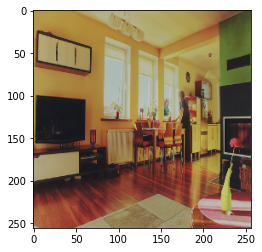

In [10]:
train_dataset = PedDataset(img_train)
test_dataset = PedDataset(img_test)
img = train_dataset[0]
print(img.shape)
img = img.permute(1,2,0)
plt.figure()
plt.imshow(img.cpu().numpy())

# Training Parameters

In [11]:
NUM_EPOCH = 22
BATCH_SIZE = 1
LR1 = 0.0001
LR2 = 0.001
SAVE_PATH = "/content/drive/MyDrive/image and video processing/model_test5_80_2/"

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)
lmda_array = np.array([64, 256, 1024, 4096])

In [13]:
'''
def train_epoch(net, data_loader, lmda_array, optimizer, aux_optimizer, criterion, epoch):
    net.train()
    
    loss_stat = []
    aux_loss_stat = []
    for i, img in enumerate(data_loader):
        for j, lmda in enumerate(lmda_array):
            img = img.to(device)
        
            optimizer.zero_grad()
            aux_optimizer.zero_grad()
        
            x_r, y_likelihoods = net(img,lmda)
            loss = criterion(img, x_r, y_likelihoods, lmda)
            loss.backward()
            optimizer.step()
        
            aux_loss = net.entropy_bottleneck.loss()
            aux_loss.backward()
            aux_optimizer.step()
        
            loss_stat += [loss.item()]*img.shape[0]
            aux_loss_stat += [aux_loss.item()]*img.shape[0]
    
    print ("Train Epoch {}: R_D_Loss: {:.3f}, aux_Loss: {:.3f}".format(epoch,np.mean(loss_stat),np.mean(aux_loss_stat))) 
    
    return np.mean(loss_stat),np.mean(aux_loss_stat)
'''

'\ndef train_epoch(net, data_loader, lmda_array, optimizer, aux_optimizer, criterion, epoch):\n    net.train()\n    \n    loss_stat = []\n    aux_loss_stat = []\n    for i, img in enumerate(data_loader):\n        for j, lmda in enumerate(lmda_array):\n            img = img.to(device)\n        \n            optimizer.zero_grad()\n            aux_optimizer.zero_grad()\n        \n            x_r, y_likelihoods = net(img,lmda)\n            loss = criterion(img, x_r, y_likelihoods, lmda)\n            loss.backward()\n            optimizer.step()\n        \n            aux_loss = net.entropy_bottleneck.loss()\n            aux_loss.backward()\n            aux_optimizer.step()\n        \n            loss_stat += [loss.item()]*img.shape[0]\n            aux_loss_stat += [aux_loss.item()]*img.shape[0]\n    \n    print ("Train Epoch {}: R_D_Loss: {:.3f}, aux_Loss: {:.3f}".format(epoch,np.mean(loss_stat),np.mean(aux_loss_stat))) \n    \n    return np.mean(loss_stat),np.mean(aux_loss_stat)\n'

In [14]:
def train_epoch(net, data_loader, lmda_array, optimizer, aux_optimizer, criterion, epoch):
    net.train()
    #loss_sum = 0
    loss_stat = []
    aux_loss_stat = []
    for i, img in enumerate(data_loader):
        img = img.to(device)
        optimizer.zero_grad()
        aux_optimizer.zero_grad()
        loss_sum = 0
        for j, lmda in enumerate(lmda_array):
            #img = img.to(device)
            #optimizer.zero_grad()
            #aux_optimizer.zero_grad()
            lamda = lmda/np.max(lmda_array)
            x_r, y_likelihoods = net(img,lamda)
            loss = criterion(img, x_r, y_likelihoods, lmda)
            loss_sum = loss_sum + loss
        loss = loss_sum
        loss.backward()
        optimizer.step()
        aux_loss = net.entropy_bottleneck.loss()
        aux_loss.backward()
        aux_optimizer.step()
        
        loss_stat += [loss.item()]*img.shape[0]
        aux_loss_stat += [aux_loss.item()]*img.shape[0]
        loss_sum = 0
    
    print ("Train Epoch {}: R_D_Loss: {:.3f}, aux_Loss: {:.3f}".format(epoch,np.mean(loss_stat),np.mean(aux_loss_stat))) 
    
    return np.mean(loss_stat),np.mean(aux_loss_stat)

In [15]:
def eval_epoch(net, data_loader, criterion, epoch):
    net.eval()
    
    loss_stat = []
    aux_loss_stat = []
    for i, img in enumerate(data_loader):
        img = img.to(device)
        with torch.no_grad():
            x_r, y_likelihoods = net(img)
            loss = criterion(img, x_r, y_likelihoods)
            aux_loss = net.entropy_bottleneck.loss()
        
    print ("Evaluate: R_D_Loss: {:.3f}, aux_Loss: {:.3f} ".format(np.mean(loss_stat),np.mean(aux_loss_stat)))
    
    return np.mean(loss_stat),np.mean(aux_loss_stat)

In [16]:
net = Network(128)
net.to(device)
print(net)

parameters = set(p for n, p in net.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in net.named_parameters() if n.endswith(".quantiles"))
optimizer = optim.Adam(parameters, lr=LR1)
aux_optimizer = optim.Adam(aux_parameters, lr=LR2)
criterion = RDLoss()
train_loss_list = []
val_loss_list = []

Network(
  (entropy_bottleneck): EntropyBottleneck(
    (likelihood_lower_bound): LowerBound()
  )
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (gdn1): GDN(
    (beta_reparam): NonNegativeParametrizer(
      (lower_bound): LowerBound()
    )
    (gamma_reparam): NonNegativeParametrizer(
      (lower_bound): LowerBound()
    )
  )
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (gdn2): GDN(
    (beta_reparam): NonNegativeParametrizer(
      (lower_bound): LowerBound()
    )
    (gamma_reparam): NonNegativeParametrizer(
      (lower_bound): LowerBound()
    )
  )
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (gdn3): GDN(
    (beta_reparam): NonNegativeParametrizer(
      (lower_bound): LowerBound()
    )
    (gamma_reparam): NonNegativeParametrizer(
      (lower_bound): LowerBound()
    )
  )
  (deconv1): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output

In [17]:
checkpoint_path = '/content/drive/MyDrive/image and video processing/model_test5_80_2/PedSegEpoch22.pth'
net.load_state_dict(torch.load(checkpoint_path))

# Training

In [ ]:
for epoch in range(NUM_EPOCH):    
    loss, aux_loss = train_epoch(net, train_loader, lmda_array, optimizer, aux_optimizer, criterion, epoch)
    #val_loss, val_aux_loss = eval_epoch(net, test_loader, criterion, epoch)
    
    # Record losses for each epoch
    train_loss_list.append(loss)
    #val_loss_list.append(val_loss)
    
    # Save the model after each epoch
    if os.path.isdir(SAVE_PATH):
        torch.save(net.state_dict(),SAVE_PATH + 'PedSegEpoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(SAVE_PATH, exist_ok=True)
        torch.save(net.state_dict(),SAVE_PATH + 'PedSegEpoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved to {}'.format(epoch + 1, SAVE_PATH + 'PedSegEpoch{}.pth'.format(epoch + 1))) 

Train Epoch 0: R_D_Loss: 12.043, aux_Loss: 608.371
Checkpoint 1 saved to /content/drive/MyDrive/image and video processing/model_test5_80_2/PedSegEpoch1.pth
Train Epoch 1: R_D_Loss: 11.394, aux_Loss: 599.936
Checkpoint 2 saved to /content/drive/MyDrive/image and video processing/model_test5_80_2/PedSegEpoch2.pth
Train Epoch 2: R_D_Loss: 11.353, aux_Loss: 594.619
Checkpoint 3 saved to /content/drive/MyDrive/image and video processing/model_test5_80_2/PedSegEpoch3.pth
Train Epoch 3: R_D_Loss: 11.290, aux_Loss: 591.751
Checkpoint 4 saved to /content/drive/MyDrive/image and video processing/model_test5_80_2/PedSegEpoch4.pth
Train Epoch 4: R_D_Loss: 11.508, aux_Loss: 571.670
Checkpoint 5 saved to /content/drive/MyDrive/image and video processing/model_test5_80_2/PedSegEpoch5.pth
Train Epoch 5: R_D_Loss: 11.515, aux_Loss: 550.513
Checkpoint 6 saved to /content/drive/MyDrive/image and video processing/model_test5_80_2/PedSegEpoch6.pth
Train Epoch 6: R_D_Loss: 11.061, aux_Loss: 526.600
Checkpo

[12.043181063607335, 11.393844130448997, 11.35308738052845, 11.290141131728888, 11.50798250362277, 11.51488771662116, 11.060801589861512, 11.277734529227018, 11.24336567055434, 11.005807182751596, 11.829074163921177, 11.349801694974303, 10.878244603052735, 10.87987545877695, 10.856747492216527, 11.15056479535997, 10.850581801496446, 10.856451285071671, 10.899079260416329, 10.70625731907785, 10.727249649353325, 11.275232982821763]


<Figure size 432x288 with 0 Axes>

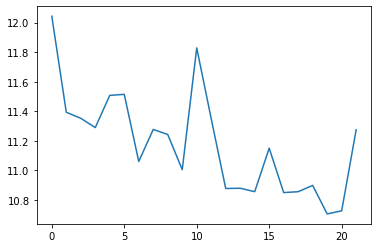

In [ ]:
print(train_loss_list)
x = np.array(range(0,len(train_loss_list)))
fig = plt.figure() 
plt.figure()
plt.plot(train_loss_list, label = 'train loss')

In [ ]:
'''
def predict_img(net, img, res):
    net.eval()

    # convert from Height*Width*Channel TO Batch*Channel*Height*Width(Batch=1) and normalize to range (0,1)
    img = cv2.resize(img, res)
    img = torch.Tensor(img).permute(2,0,1)
    img = img.unsqueeze(0)
    img = img/255.
    img = img.to(device)

    with torch.no_grad():
        pred,y = net(img,4096)
        print(pred.shape)
        pred = pred.squeeze(0)
        pred = torch.Tensor(pred).permute(1,2,0)
        pred[pred>1] = 1
        pred[pred<=0] = 0
    return pred
'''

'\ndef predict_img(net, img, res):\n    net.eval()\n\n    # convert from Height*Width*Channel TO Batch*Channel*Height*Width(Batch=1) and normalize to range (0,1)\n    img = cv2.resize(img, res)\n    img = torch.Tensor(img).permute(2,0,1)\n    img = img.unsqueeze(0)\n    img = img/255.\n    img = img.to(device)\n\n    with torch.no_grad():\n        pred,y = net(img,4096)\n        print(pred.shape)\n        pred = pred.squeeze(0)\n        pred = torch.Tensor(pred).permute(1,2,0)\n        pred[pred>1] = 1\n        pred[pred<=0] = 0\n    return pred\n'

In [ ]:
'''
idx = 2
img_path = img_test[idx]
img = cv2.imread(img_path)
################################################ [TODO] ###################################################

# Predict the mask
pred = predict_img(net=net,
                   img=img,
                   res=(256,256))
img_r = cv2.resize(img, (256,256))
img_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB)
print(pred.shape)
pred = pred.cpu().numpy()
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (16,32))
plt.subplot(1,2,1)
plt.imshow(img_r)
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Reconstructed Image')
'''

"\nidx = 2\nimg_path = img_test[idx]\nimg = cv2.imread(img_path)\n################################################ [TODO] ###################################################\n\n# Predict the mask\npred = predict_img(net=net,\n                   img=img,\n                   res=(256,256))\nimg_r = cv2.resize(img, (256,256))\nimg_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB)\nprint(pred.shape)\npred = pred.cpu().numpy()\npred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)\nplt.figure(figsize = (16,32))\nplt.subplot(1,2,1)\nplt.imshow(img_r)\nplt.title('Image')\nplt.subplot(1,2,2)\nplt.imshow(pred)\nplt.title('Reconstructed Image')\n"

In [18]:
class BPPLoss(nn.Module):
    def __init__(self):
        super(BPPLoss, self).__init__()
        
    def forward(self, x, x_r, y_likelihoods, lmda):
        N, _, H, W = x.size()
        num_pixels = N*H*W
        R_Loss = torch.log(y_likelihoods).sum()/(-math.log(2)*num_pixels)
        return R_Loss
bpp = BPPLoss()

In [19]:
def predict_img(net, bpp, img, tf):
    net.eval()

    img = torch.Tensor(img).permute(2,0,1)
    img = img.unsqueeze(0)
    img = img/255.
    img = img.to(device)

    with torch.no_grad():
        pred,y = net(img,tf)
        loss = bpp(img, pred, y, tf)
        mse = F.mse_loss(img, pred)
        pred = pred.squeeze(0)
        pred = torch.Tensor(pred).permute(1,2,0)
        pred[pred>1] = 1
        pred[pred<=0] = 0
    return pred, loss, mse

tensor(1.0810)
tensor(0.0004)


Text(0.5, 1.0, 'Reconstructed Image')

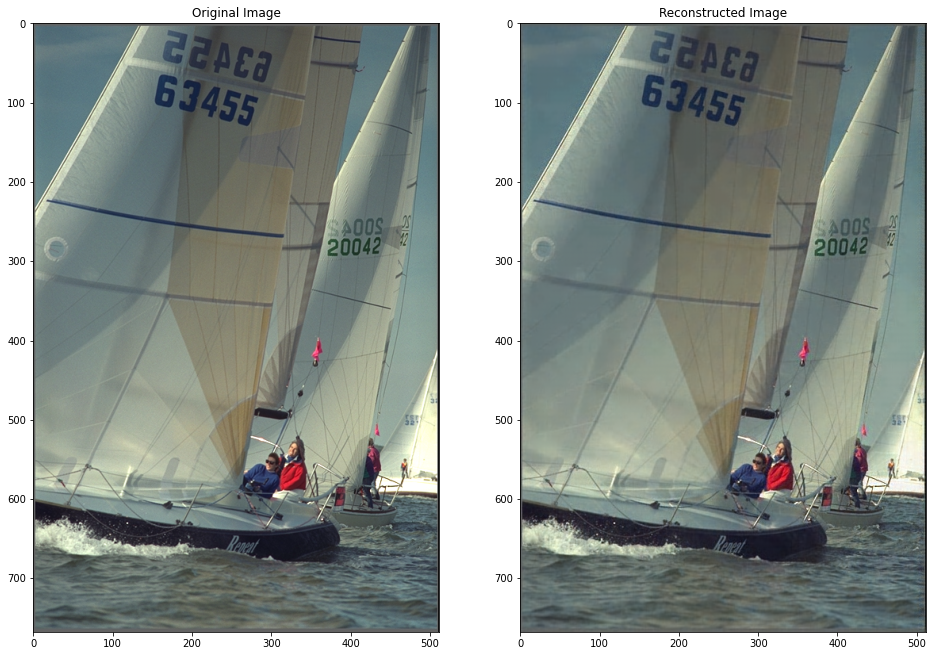

In [36]:
idx = 9
img_path = img_test[idx]
img = cv2.imread(img_path)
'''
cv2.imwrite('x.jpg', img)
n = os.path.getsize('x.jpg')
n = n/(img.shape[0]*img.shape[1])
print(img.shape)
print(n)
'''
#img = cv2.resize(img, (256,256))
################################################ [TODO] ###################################################

# Predict the mask
pred, bppLoss, mse = predict_img(net=net, bpp=bpp,
                   img=img,
                   tf=4096/4096)  #64/4096
print(bppLoss)
print(mse)
pred = pred.cpu().numpy()
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (16,32))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Reconstructed Image')

In [37]:
psnr = 10 * np.log10(1**2 / mse)
print(psnr)

tensor(34.2442)


In [38]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pytorch_msssim

In [39]:
img1 = cv2.imread(img_path)
img1=img1/255
img1=torch.Tensor(img1).permute(2,0,1)
img1 = img1.unsqueeze(0)
pred1=torch.Tensor(pred).permute(2,0,1)
pred1 = pred1.unsqueeze(0)
#print(img1.shape)
#print(pred1.shape)
ssim_val = ssim( img1, pred1, data_range=1, size_average=False)
ms_ssim_val = ms_ssim( img1, pred1, data_range=1, size_average=False ) 
print(ssim_val,ms_ssim_val)

tensor([0.9041]) tensor([0.9054])


In [40]:
'''
cv2.imwrite('/content/drive/MyDrive/Project/kodim10.jpg', img)
n = os.path.getsize('/content/drive/MyDrive/Project/kodim10.jpg')
n = n/(img.shape[0]*img.shape[1])
print(img.shape)
print(n)
'''

(768, 512, 3)
0.35612233479817706
